# Practice Goals for this Version:

In the next few versions I want to make one small change to the notebook and see how it effects the result. This is in line with the "Edysonian" approach of iterative testing.

Some of the things I'll test in the next few versions:
1. Changing scaling algorithm to standard scaler.
2. Changing age imputation to titles from names.
3. Create an encoded title feature?
4. Delete n_of_rel feature.
5. Delete has cabin or not feature.
6. Fix the merging and splitting of the test/ training set to keep its independence.

This version will check changes in the scaling algorithm.

# Debrief

1. Changing scaling algorithm has exactly zero difference in results. I'd still presume robust scaler is better because some of the data is skewed.
2. 


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas import Series, DataFrame
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [4]:
train = pd.read_csv("/kaggle/input/titanic/train.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
test = pd.read_csv("/kaggle/input/titanic/test.csv")
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
gen_sub = pd.read_csv("/kaggle/input/titanic/gender_submission.csv")
gen_sub.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


# Data Exploration

In [ ]:
train.info()

In [ ]:
test.info()

In [ ]:
train.Fare.plot(kind="hist", bins=50)

In [ ]:
train.Age.plot(kind="hist", bins=30)
#train.Parch.plot(kind="hist", bins=30)
#train.SibSp.plot(kind="hist", bins=30)

In [ ]:
#train.plot(x="Survived", y="Pclass", kind="scatter")
#pd.crosstab(train.Pclass, train.Survived)
counts = train.groupby(["Pclass", "Survived"]).size().unstack()
counts.plot(kind="bar")

In [ ]:
counts = train.groupby(["Embarked", "Survived"]).size().unstack()
counts.plot(kind="bar")

In [ ]:
counts = train.groupby(["Parch", "Survived"]).size().unstack()
counts.plot(kind="bar")
# seems like it helps to have family members

In [ ]:
# Does missing age correlates with the class passenger is in?

# Calculate missing age percentage by class
missing_pct = train.groupby('Pclass')['Age'].apply(lambda x: x.isna().mean() * 100)

# Plot it
missing_pct.plot(kind='bar', figsize=(6, 4), color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title('Missing Age % by Passenger Class')
plt.xlabel('Passenger Class')
plt.ylabel('Missing %')
plt.xticks(rotation=0)
plt.show()

print(missing_pct)

# Handle Missing Values

Previously for handling missing age values I used simple median across all train and test sets, now we'll use more sophisticated approaches. 

Specifically, we'll first merge train and test sets, then group passengers by sex and class, and then impute the mean of each group. 

(In the future versions final improvement we'll be using extracted titles from names.)

In [7]:
# Merging datasets.
combined = pd.concat([train, test], axis=0, ignore_index=True)
combined.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
# Calculate mean age for each Pclass-Sex group
age_means = combined.groupby(['Pclass', 'Sex'])['Age'].mean()
print("\nMean ages by group:")
print(age_means)


Mean ages by group:
Pclass  Sex   
1       female    37.037594
        male      41.029272
2       female    27.499223
        male      30.815380
3       female    22.185329
        male      25.962264
Name: Age, dtype: float64


In [9]:
# Impute
combined['Age'] = combined.groupby(['Pclass', 'Sex'])['Age'].transform(
    lambda x: x.fillna(x.mean())
)

In [ ]:
combined.info()

In [ ]:
# It might be useful to do other data processing while our datasets are merged. 

Cabin will be converted to binary "has cabin". Which will have to be numeric 0/1.

In [10]:
combined['HasCabin'] = combined['Cabin'].notna().astype(int)
combined = combined.drop('Cabin', axis=1)

combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1309 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Embarked     1307 non-null   object 
 11  HasCabin     1309 non-null   int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 122.8+ KB


Missing fare instances will be replaced with median, while missing embarked with mode.

In [11]:
embarked_mode = combined['Embarked'].mode()[0]  # mode() returns a Series, so we take first value
combined['Embarked'].fillna(embarked_mode, inplace=True)
combined['Fare'].fillna(combined['Fare'].median(), inplace=True)

combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1309 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1309 non-null   float64
 10  Embarked     1309 non-null   object 
 11  HasCabin     1309 non-null   int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 122.8+ KB


/tmp/ipykernel_36/2776746238.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined['Embarked'].fillna(embarked_mode, inplace=True)
/tmp/ipykernel_36/2776746238.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

# Feature Selection
To limit the complexity of data (and save myself time for this version), I will drop Ticket, Name and PassengerId (it's test values will be used later for submission).

In [12]:
combined = combined.drop(['Ticket', 'Name', 'PassengerId'], axis=1)
combined.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,HasCabin
0,0.0,3,male,22.0,1,0,7.2500,S,0
1,1.0,1,female,38.0,1,0,71.2833,C,1
2,1.0,3,female,26.0,0,0,7.9250,S,0
3,1.0,1,female,35.0,1,0,53.1000,S,1
4,0.0,3,male,35.0,0,0,8.0500,S,0


# Encoding Categorical Variables
For Sex numerical 0/1. For embarked one-hot encoding.

In [13]:
combined['Sex'] = combined["Sex"].map({'male':0,'female':1})
combined.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,HasCabin
0,0.0,3,0,22.0,1,0,7.2500,S,0
1,1.0,1,1,38.0,1,0,71.2833,C,1
2,1.0,3,1,26.0,0,0,7.9250,S,0
3,1.0,1,1,35.0,1,0,53.1000,S,1
4,0.0,3,0,35.0,0,0,8.0500,S,0


In [14]:
# Creates 3 columns: Embarked_C, Embarked_Q, Embarked_S
embarked_encoded = pd.get_dummies(combined['Embarked'], prefix='Embarked')
combined = pd.concat([combined.drop('Embarked', axis=1), embarked_encoded], axis=1)
combined.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,HasCabin,Embarked_C,Embarked_Q,Embarked_S
0,0.0,3,0,22.0,1,0,7.2500,0,False,False,True
1,1.0,1,1,38.0,1,0,71.2833,1,True,False,False
2,1.0,3,1,26.0,0,0,7.9250,0,False,False,True
3,1.0,1,1,35.0,1,0,53.1000,1,False,False,True
4,0.0,3,0,35.0,0,0,8.0500,0,False,False,True


# Outlier Handling

Percentage clipping for Fare feature (recommended by Claude, not my level yet to differentiate which techniques are better depending on the case).

In [15]:
print(combined['Fare'].describe())
print(f"95th percentile: ${combined['Fare'].quantile(0.95):.2f}")
print(f"97th percentile: ${combined['Fare'].quantile(0.97):.2f}")
print(f"975th percentile: ${combined['Fare'].quantile(0.975):.2f}")
print(f"98th percentile: ${combined['Fare'].quantile(0.98):.2f}")
print(f"99th percentile: ${combined['Fare'].quantile(0.99):.2f}")

count    1309.000000
mean       33.281086
std        51.741500
min         0.000000
25%         7.895800
50%        14.454200
75%        31.275000
max       512.329200
Name: Fare, dtype: float64
95th percentile: $133.65
97th percentile: $164.87
975th percentile: $211.50
98th percentile: $221.78
99th percentile: $262.38


<Axes: ylabel='Frequency'>

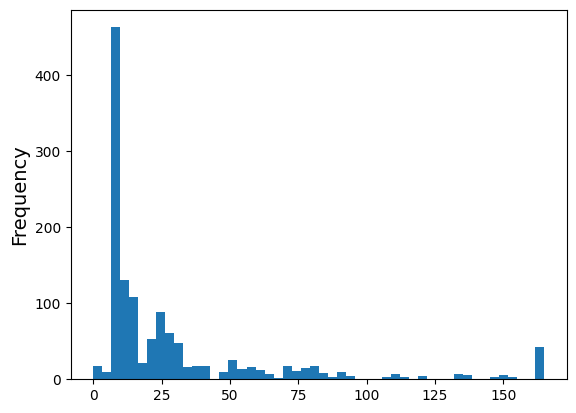

In [16]:
fare_cap = combined['Fare'].quantile(0.97)
combined['Fare'] = combined['Fare'].clip(upper=fare_cap)
combined.Fare.plot(kind="hist", bins=50)

# Feature Engineering

In this version I'll create a single feature of N_of_rel on titanic, which is SibSp+Parch.

In [17]:
combined['n_of_rel'] = combined['SibSp'] + combined['Parch']
combined = combined.drop(['SibSp', 'Parch'], axis=1)

combined.head()

,Survived,Pclass,Sex,Age,Fare,HasCabin,Embarked_C,Embarked_Q,Embarked_S,n_of_rel
0,0.0,3,0,22.0,7.2500,0,False,False,True,1
1,1.0,1,1,38.0,71.2833,1,True,False,False,1
2,1.0,3,1,26.0,7.9250,0,False,False,True,0
3,1.0,1,1,35.0,53.1000,1,False,False,True,1
4,0.0,3,0,35.0,8.0500,0,False,False,True,0


In [18]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    float64
 1   Pclass      1309 non-null   int64  
 2   Sex         1309 non-null   int64  
 3   Age         1309 non-null   float64
 4   Fare        1309 non-null   float64
 5   HasCabin    1309 non-null   int64  
 6   Embarked_C  1309 non-null   bool   
 7   Embarked_Q  1309 non-null   bool   
 8   Embarked_S  1309 non-null   bool   
 9   n_of_rel    1309 non-null   int64  
dtypes: bool(3), float64(3), int64(4)
memory usage: 75.5 KB


# Feature Scaling
Previously I used standard scaler, but because some of the data is skewed, like fare price, I'll apply robust scaler.

In [19]:
from sklearn.preprocessing import StandardScaler

# Exclude survived from scaling and scale
cols_to_scale = combined.columns.drop("Survived")
std_scale = StandardScaler()
combined_scaled = std_scale.fit_transform(combined[cols_to_scale])

# Remerge
combined_final = pd.DataFrame(combined_scaled, columns=cols_to_scale)
combined_final['Survived'] = combined['Survived'].values

combined_final.head()

,Pclass,Sex,Age,Fare,HasCabin,Embarked_C,Embarked_Q,Embarked_S,n_of_rel,Survived
0,0.841916,-0.743497,-0.560331,-0.623622,-0.539377,-0.50977,-0.32204,0.655011,0.073352,0.0
1,-1.546098,1.344995,0.655107,1.106913,1.853992,1.96167,-0.32204,-1.526692,0.073352,1.0
2,0.841916,1.344995,-0.256471,-0.605380,-0.539377,-0.50977,-0.32204,0.655011,-0.558346,1.0
3,-1.546098,1.344995,0.427212,0.615500,1.853992,-0.50977,-0.32204,0.655011,0.073352,1.0
4,0.841916,-0.743497,0.427212,-0.602001,-0.539377,-0.50977,-0.32204,0.655011,-0.558346,0.0


# Training the Model!

In [21]:
# First, separate the training and test sets.

# Split based on NaN in Survived column
train_final = combined_final[combined_final['Survived'].notna()].copy()
test_final = combined_final[combined_final['Survived'].isna()].copy()

# For train set, convert Survived to int (it's probably float due to NaNs)
train_final['Survived'] = train_final['Survived'].astype(int)

# For test set, you probably want to drop the Survived column
test_final = test_final.drop('Survived', axis=1)

In [22]:
# Final dataset prep before training

x_train = train_final.drop("Survived", axis=1)
y_train = train_final["Survived"]
x_test = test_final

In [ ]:
x_train.head()
#y_train.head()
#x_test.head()

## Shortlisting models on k-fold cross validation scores

In [23]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

knn = KNeighborsClassifier(n_neighbors=5)
log = LogisticRegression(max_iter=1000, random_state=42)
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
xgb = XGBClassifier(n_estimators = 100, random_state=42, eval_metric="logloss")

cv_scores_knn = cross_val_score(knn, x_train, y_train, cv=5, scoring='accuracy')
cv_scores_log = cross_val_score(log, x_train, y_train, cv=5, scoring='accuracy')
cv_scores_rfc = cross_val_score(rfc, x_train, y_train, cv=5, scoring='accuracy')
cv_scores_svm = cross_val_score(svm, x_train, y_train, cv=5, scoring='accuracy')
cv_scores_xgb = cross_val_score(xgb, x_train, y_train, cv=5, scoring='accuracy')

print(cv_scores_knn.mean(), cv_scores_knn.std())
print(cv_scores_log.mean(), cv_scores_log.std())
print(cv_scores_rfc.mean(), cv_scores_rfc.std())
print(cv_scores_svm.mean(), cv_scores_svm.std())
print(cv_scores_xgb.mean(), cv_scores_xgb.std())

0.7979850605737242 0.014995006824560378
0.797991337643588 0.01357340849687361
0.808097420124286 0.03532422725044903
0.8125729709371665 0.023702397002166118
0.8238089259933463 0.02637951885049842


## Finetuning
Not surprisingly, xgboost performs the best. I'll proceed to finetune it.

In [24]:
from sklearn.model_selection import GridSearchCV

# From claude I got these parameters for finetuning
xgb_params = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'min_child_weight': [1, 3, 5]
}

# Run grid search
xgb = XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False,
    gamma=0,  # Minimum loss reduction
    reg_alpha=0.1,  # L1 regularization
)

xgb_grid = GridSearchCV(
    xgb, 
    xgb_params, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1,  # Use all cores
    verbose=1
)

xgb_grid.fit(x_train, y_train)
print(f"Best params: {xgb_grid.best_params_}")
print(f"Best score: {xgb_grid.best_score_:.4f}")

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best params: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 150, 'subsample': 0.9}
Best score: 0.8440


# Submission

In [25]:
# Predict on scaled test data
test_preds = xgb_grid.predict(x_test)

# Build Kaggle submission file
submission = pd.DataFrame({
    "PassengerId": test['PassengerId'],
    "Survived": test_preds
})

# Save to CSV
submission.to_csv("submission.csv", index=False)
print("Submission file created: submission.csv")

Submission file created: submission.csv
